<b> Final Part : Detectig QR </b><br><br>
<font color='red'> method 1 : segmentation</font>

In [1]:
from Image import Show
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
import cv2
from math import ceil
import matplotlib.pyplot as plt
from pyzbar import pyzbar

In [2]:
# get corners coordinate and return width , height and correspondent warped image

def four_point_transform(image, pts):
    (tl, tr, br, bl) = pts
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    maxWidth = max(int(widthA), int(widthB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped,maxWidth,maxHeight

In [3]:
# get input image and some other paramethers and return:  
# 1. array of corners as pts 
# 2. original image or image with numbers on it depends on 'num' value

def QR_point(image,inv=True,ratio=20,num=False):
    tmp=image.copy()
    min_=ceil(min((tmp.shape)[1:2])/ratio )
    shifted = cv2.pyrMeanShiftFiltering(tmp, 21, 51)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    if inv==False:
        thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    else:
        thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=min_,labels=thresh)
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    pts=[]
    for label in np.unique(labels):
        if label != 0: #foreground
            mask = np.zeros(gray.shape, dtype="uint8")
            mask[labels == label] = 255
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)
            ((x_, y_), r) = cv2.minEnclosingCircle(c)
            [x,y,w,h]=cv2.boundingRect(c)
            if num==True:
                cv2.putText(tmp,"{}".format(label),(int(x_)-10,int(y_)),cv2.FONT_HERSHEY_SIMPLEX, 0.8,(255, 0, 0), 2)
                P=np.array([(x,y),(x+w,y),(x+w,y+h),(x,y+h)],dtype = "float32")
            else:
                P=np.array([(x,y+h),(x+w,y+h),(x+w,y),(x,y)],dtype = "float32")
            pts.append(P)
    return pts,tmp



In [4]:
# get input image and start segmentation with QR_point( initial ratio is 60) then
# for each segment comes from rows in pts ,code will check if thw segment contains Qr-code or not
# if code find Qr it will return that segment,size of it , index of it in pts array and corner points
# if code didnt find Qr ,it will decrease ratio by 5 and repeat the process . 
#if until ratio reach zero no Qr found ;
# the process will start again with ratio= 60 and inverse thresholding.

def QR_segment(img):
    Rate=60
    Inv=True
    while(True):
        tmp=img.copy()
        Next=True
        warped,Qr,size=[],[],[]
        pts,_= QR_point(tmp,inv=Inv,ratio=Rate)
        for row in pts:
            [warp,width,height]=four_point_transform(tmp,row)
            Qr.append(pyzbar.decode(warp))
            warped.append(warp)
            size.append(str(width)+'*'+str(height))
        for i in range(len(Qr)):
            if Qr[i]!=[]:
                if min(int(width),int(height)) < min(np.shape(tmp)[0:2])-20:
                    Next=False
                    break
        if Next==False:
            break
        Rate=Rate-5
        if Rate==0:
            if Inv==False:
                warped,Qr,size,i=[],[],[],-1
                break
            else:
                Inv=False
                Rate=60
    return warped,Qr,size,i,pts

In [5]:
# in this final function i implement previous function to get result

def qrcode(img):
    tmp=img.copy()
    warp,qr,pixel,index,pts=QR_segment(tmp.copy())
    if index==-1:
        print('no Qr_code found !')
        Img=cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
        title='';wr=[];link=''
    else:
        corners=pts[index]
        [x,y]=corners[3]
        [w,h]=corners[1]
        barcode=qr[index][0]
        barcodeData = barcode.data.decode("utf-8")
        barcodeType = barcode.type;
        text = "{} ({})".format(barcodeData, barcodeType);
        link=text+'\n\n'
        cv2.rectangle(tmp,(int(x-2),int(y-2)),(int(w+2),int(h+2)), (0,0,255), 2)
        try:
            text_=text[8:25]+'...'
        except:
            text_=text
        cv2.putText(tmp, text_, (int(x-25), int(y - 10)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2);
        Img=cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
        title='result\n'+str(pixel[index])
        wr=warp[index]
    return title,wr,Img,link

https://docs.google.com/forms/d/e/1FAIpQLSfzC5ZIV_maMJxVM-jS5ImQcMa5RoLTzvBCdz7eL8kRKgoszg/viewform?usp=send_form (QRCODE)




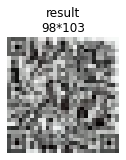

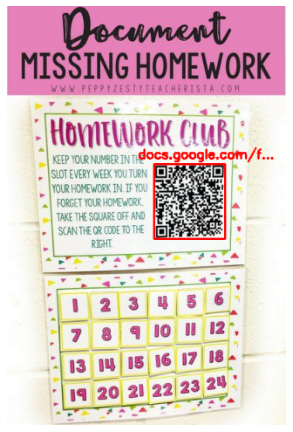

In [6]:
img2 = cv2.imread('images\qr4.png')
title2,warp2,Img2,link2=qrcode(img2)
if link2!='':
    print(link2)
    Show.show_me(warp2,title2,scale=0.3);plt.show()   
Show.show_me(Img2,scale=0.8)

<font color='red'>method 2 : pyzbar  </font>

QRCODE barcode: https://docs.google.com/forms/d/e/1FAIpQLSfzC5ZIV_maMJxVM-jS5ImQcMa5RoLTzvBCdz7eL8kRKgoszg/viewform?usp=send_form



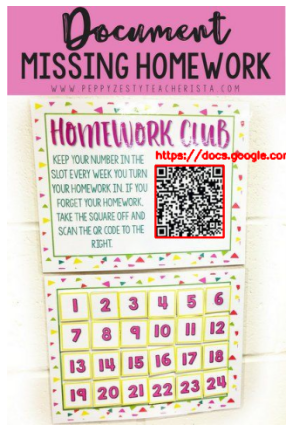

In [7]:
img2 = cv2.imread('images\qr4.png')

barcodes = pyzbar.decode(img2)
for barcode in barcodes:
    (x, y, w, h) = barcode.rect
#draw rectangle around QR :
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2) 
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
#put QR link on image :
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(img2, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 255), 2)
    print("{} barcode: {}\n".format(barcodeType, barcodeData))
# show the result :
    Show.show_me(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),scale=0.8)
    